In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox
from scipy.stats import boxcox,skew

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression,Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
'''在clean_4.ipynb中已经去除了工资为0的个体'''
'''不丢弃Overall，Value：工资可能要参考这两部分'''

data = pd.read_csv("./train.csv", index_col=0)
Y = data['Wage']
X = data.drop(['Wage'],axis=1)

X.shape, Y.shape

((17904, 727), (17904,))

PART 1.特征选择
=

1.划分数据集
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 727), (3581, 727), (2865, 727), (11458,), (3581,), (2865,))

2.特征选择
=

In [4]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

impt = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
print(len(impt))
impt.sort_values("Feature Importance", ascending=False).round(5).head(10)

727


,Feature Importance
PLAYER_BODY_TYPE_25,134.31061
Real Madrid,102.76821
FC Barcelona,86.82111
SpecialBody,77.59964
Manchester City,73.08663
Juventus,68.35339
Manchester United,57.42081
Chelsea,55.79374
Arsenal,51.00677
Tottenham Hotspur,37.12125


In [6]:
impt = impt[impt["Feature Importance"] != 0].sort_values("Feature Importance")
# impt.plot(kind="barh", figsize=(10, 25))
display(impt.shape)

(569, 1)

In [7]:
chooseFeatures = impt.index.to_list()
chooseData = X[chooseFeatures].copy()
chooseData.shape

(17904, 569)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(chooseData, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 569), (3581, 569), (2865, 569), (11458,), (3581,), (2865,))

3.建模
=

LinearRegression
=

In [9]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 77.1033572957189
测试集MSE = 97.51313212921133

训练集MAPE = 1.458871931926007
测试集MAPE = 1.5768852525764891

训练集R2_Score = 0.8287632296415426
测试集R2_Score = 0.7763712118768942


RandomForest
=
Overfitting!<br>
trainSet R2 = 0.97<br>
testSet R2 = 0.79

In [10]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 11.697007466666669
测试集MSE = 89.59221544261378

训练集MAPE = 0.23619388611492
测试集MAPE = 0.6981298276665598

训练集R2_Score = 0.9740224310367095
测试集R2_Score = 0.7945364062540039


In [13]:
rfc = RandomForestRegressor(n_estimators=300)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)


print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 11.440452311111109
测试集MSE = 88.07016775885073

训练集MAPE = 0.23307152946305754
测试集MAPE = 0.7033971401836463

训练集R2_Score = 0.9745922074744288
测试集R2_Score = 0.7980269482102862


XGB
=

In [14]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 10.35612740794567
测试集MSE = 73.64929382230308

训练集MAPE = 0.4410314767153157
测试集MAPE = 0.5420858395915289

训练集R2_Score = 0.9770003554585063
测试集R2_Score = 0.8310986226780184


In [15]:
xgb_params = {
    'n_estimators':[300,400,500,600,700]
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 700}

训练集MSE = 0.39976532638426593
测试集MSE = 67.94435229898083

训练集MAPE = 0.1434528995811856
测试集MAPE = 0.4502721675264086

训练集R2_Score = 0.9991121719495457
测试集R2_Score = 0.8441818775311517


LGBM
=

In [16]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 22.235506730314835
测试集MSE = 98.22810358050236

训练集MAPE = 0.585962953814308
测试集MAPE = 0.7592161286553879

训练集R2_Score = 0.9506177617508976
测试集R2_Score = 0.7747315537538942


In [17]:
lgbm_params = {
    'n_estimators':[300,400,500,600,700]  
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 300}

训练集MSE = 6.7612544184044365
测试集MSE = 100.51106421158671

训练集MAPE = 0.44712759510641004
测试集MAPE = 0.7524177298266694

训练集R2_Score = 0.9849841120959371
测试集R2_Score = 0.7694959951361517


Result
=

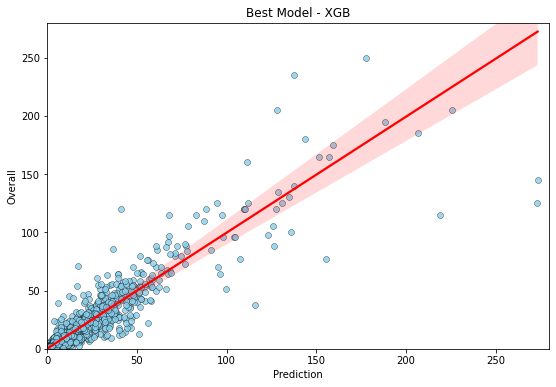

In [22]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_xgb,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - XGB")
plt.xlim(0,280)
plt.ylim(0,280)
plt.show()

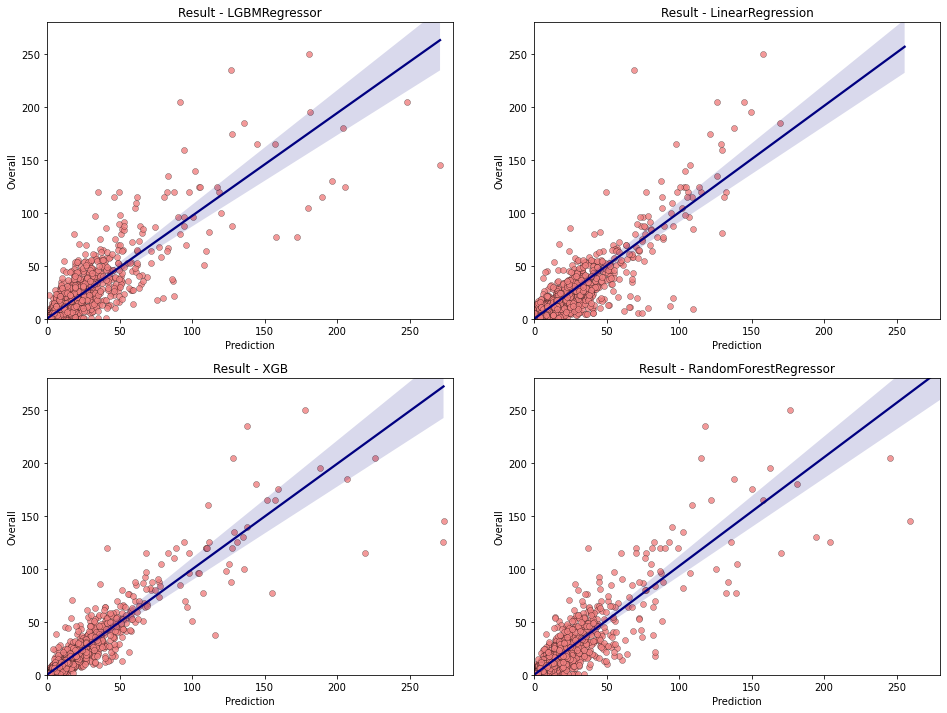

In [23]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(0,280)
    ax[r,c].set_ylim(0,280)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()

PART 2.PCA
=

1.划分数据集
=

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 727), (3581, 727), (2865, 727), (11458,), (3581,), (2865,))

In [26]:
pca = PCA(n_components=0.98) # 0.99 : 409; 0.98 : 171
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

0.9800275124383702
171


In [27]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((11458, 171), (3581, 171), (2865, 171))

3.建模
=

LinearRegression
=

In [28]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 145.75835973155023
测试集MSE = 161.6881060796026

训练集MAPE = 1.9409703076893359
测试集MAPE = 1.973757727390058

训练集R2_Score = 0.6762891831357033
测试集R2_Score = 0.6291974790781019


RandomForest
=

In [29]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 15.181302566666666
测试集MSE = 113.17215233175092

训练集MAPE = 0.33231277998191683
测试集MAPE = 0.8736155032476848

训练集R2_Score = 0.9662842538570638
测试集R2_Score = 0.7404600721706132


In [34]:
rfc = RandomForestRegressor(n_estimators=300)
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

{'n_estimators': 300}

训练集MSE = 12.952961581481482
测试集MSE = 109.93609873716218

训练集MAPE = 0.3219260641552815
测试集MAPE = 0.8785020578871621

训练集R2_Score = 0.9712331163572663
测试集R2_Score = 0.7478813776692446


XGB
=

In [30]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 2.3141027984027236
测试集MSE = 105.903741667828

训练集MAPE = 0.36142729364313786
测试集MAPE = 0.8467259233402515

训练集R2_Score = 0.9948606713977945
测试集R2_Score = 0.757128861623508


In [33]:
xgb_params = {
    'n_estimators':[300,400,500,600,700],
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 300}

训练集MSE = 0.07533225986465868
测试集MSE = 104.91140858945133

训练集MAPE = 0.082605765501455
测试集MAPE = 0.8424054413371964

训练集R2_Score = 0.9998326966122428
测试集R2_Score = 0.7594045986333477


LGBM
=

In [31]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 11.432173295358341
测试集MSE = 94.7832453228913

训练集MAPE = 0.5277470823512763
测试集MAPE = 0.751687226759777

训练集R2_Score = 0.9746105941176175
测试集R2_Score = 0.7826317151022616


In [32]:
lgbm_params = {
    'n_estimators':[300,400,500,600,700] 
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 300}

训练集MSE = 2.086502618532094
测试集MSE = 89.71487439144104

训练集MAPE = 0.31317646338177746
测试集MAPE = 0.7292286040432632

训练集R2_Score = 0.9953661425095721
测试集R2_Score = 0.7942551100687645


Result
=

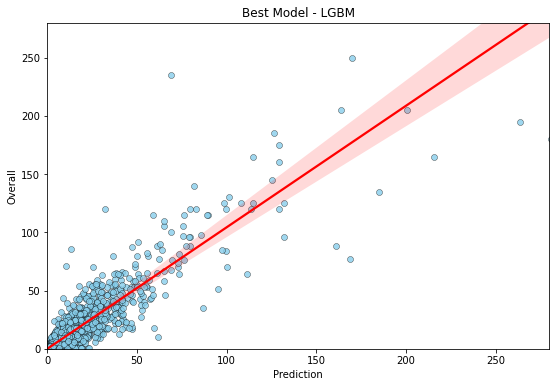

In [35]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_lgbm,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - LGBM")
plt.xlim(0,280)
plt.ylim(0,280)
plt.show()

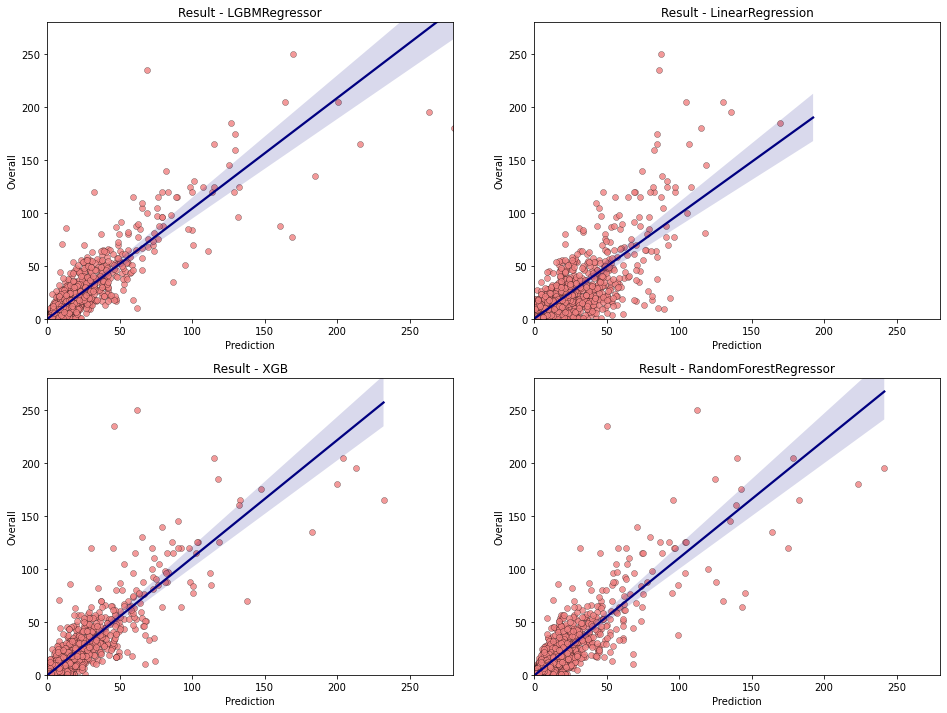

In [36]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(0,280)
    ax[r,c].set_ylim(0,280)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()

PART 3.特征选择 + PCA
=

1.划分数据集
=

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 727), (3581, 727), (2865, 727), (11458,), (3581,), (2865,))

2.特征选择
=

In [4]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

impt = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
impt.sort_values("Feature Importance", ascending=False).round(5).head(10)

,Feature Importance
PLAYER_BODY_TYPE_25,134.31061
Real Madrid,102.76821
FC Barcelona,86.82111
SpecialBody,77.59964
Manchester City,73.08663
Juventus,68.35339
Manchester United,57.42081
Chelsea,55.79374
Arsenal,51.00677
Tottenham Hotspur,37.12125


In [5]:
impt = impt[impt["Feature Importance"] != 0].sort_values("Feature Importance")
display(impt.shape)

(569, 1)

In [6]:
chooseFeatures = impt.index.to_list()
chooseData = X[chooseFeatures].copy()
chooseData.shape

(17904, 569)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(chooseData, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 569), (3581, 569), (2865, 569), (11458,), (3581,), (2865,))

3.PCA
=

In [9]:
'''
mle : 564 - 0.99999
'''
pca = PCA(n_components=0.99)
pca.fit(X_train)
print(pca.explained_variance_ratio_.sum())
print(len(pca.explained_variance_))

0.9900334196608207
280


In [10]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)

X_train.shape, X_test.shape, X_val.shape

((11458, 280), (3581, 280), (2865, 280))

4.建模
=

LinearRegressor
=

In [11]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])

r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lr}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 132.58651718440657
测试集MSE = 153.55749431922717

训练集MAPE = 1.9797517452409956
测试集MAPE = 2.0268998732743477

训练集R2_Score = 0.705542173622127
测试集R2_Score = 0.6478435713014852


RandomForest
=

In [12]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_rfc}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 13.528829533333335
测试集MSE = 106.18258841105836

训练集MAPE = 0.3145982117536162
测试集MAPE = 0.8595266180574189

训练集R2_Score = 0.9699541867271356
测试集R2_Score = 0.7564893768905383


XGB
=

In [13]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 1.9176670627012498
测试集MSE = 109.99372849625831

训练集MAPE = 0.32816610601336677
测试集MAPE = 0.7994545943664597

训练集R2_Score = 0.9957411048499443
测试集R2_Score = 0.7477492142066926


In [17]:
xgb_params = {
    'n_estimators':[200,300,400,500]
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_xgb}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 500}

训练集MSE = 0.002384124978451046
测试集MSE = 109.43453770335742

训练集MAPE = 0.015914702251353656
测试集MAPE = 0.8100120584684718

训练集R2_Score = 0.9999947051610233
测试集R2_Score = 0.7490316174750065


LGBM
=

In [14]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 10.465153922931394
测试集MSE = 83.47248348355859

训练集MAPE = 0.5122495462685684
测试集MAPE = 0.7202184839729259

训练集R2_Score = 0.9767582214067038
测试集R2_Score = 0.8085709081898902


In [16]:
lgbm_params = {
    'n_estimators':[200,300,400,500]
    
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集MAPE = {mape_train}")
print(f"测试集MAPE = {mape_lgbm}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 500}

训练集MSE = 0.5822185031763094
测试集MSE = 78.22830020087002

训练集MAPE = 0.19142588010918074
测试集MAPE = 0.6800268121286719

训练集R2_Score = 0.9987069666014091
测试集R2_Score = 0.8205974970871591


Result
=

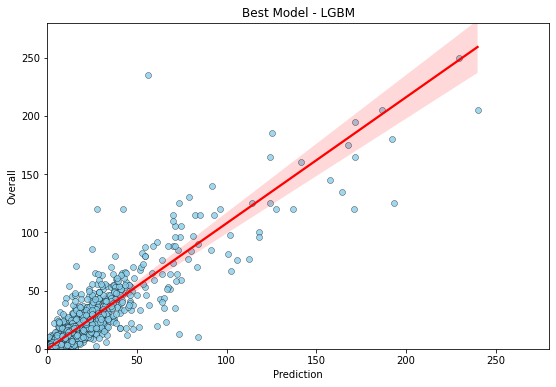

In [18]:
fig = plt.figure(figsize=(9,6))
sns.regplot(pred_lgbm,Y_test,scatter_kws={'color':'skyblue','linewidth':0.4,'edgecolor':'black'},line_kws={'color':'red'})
plt.xlabel("Prediction")
plt.ylabel("Overall")
plt.title("Best Model - LGBM")
plt.xlim(0,280)
plt.ylim(0,280)
plt.show()

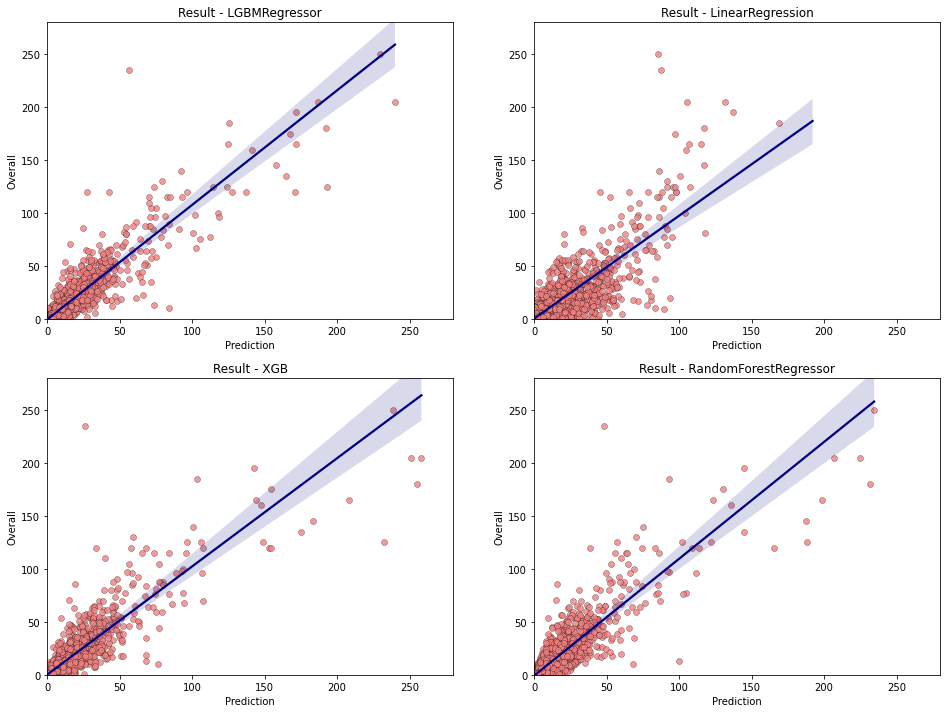

In [19]:
fig, ax = plt.subplots(2,2,figsize=(16,12))
plt.subplots_adjust(hspace=0.2,wspace=0.2)

res = [pred_lgbm, pred_lr, pred_xgb, pred_rfc]
titles = ['LGBMRegressor','LinearRegression', 'XGB', 'RandomForestRegressor']

r, c = 0, 0
for i in range(4):
    sns.regplot(res[i],Y_test,scatter_kws={'color':'lightcoral','linewidth':0.3,'edgecolor':'black'},line_kws={'color':'navy'},ax=ax[r,c])
    ax[r,c].set_xlabel("Prediction")
    ax[r,c].set_ylabel("Overall")
    ax[r,c].set_title("Result - "+titles[i])
    ax[r,c].set_xlim(0,280)
    ax[r,c].set_ylim(0,280)
    if c == 1:
        c = 0
        r += 1
    else:c += 1
plt.show()

PART 4.先对Wage作boxcox变换，再进行预测
=

In [3]:
Y = np.log(Y)
skew(Y)

0.7204158920350076

1.划分数据集 + 特征选择
=

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 727), (3581, 727), (2865, 727), (11458,), (3581,), (2865,))

In [5]:
# Y_train = np.log1p(Y_train)
# Y_test, lam_test = boxcox(Y_test)
# Y_val,lam_val = boxcox(Y_val)

# skew(Y_train)

1.033151381851932

In [5]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)

impt = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
impt = impt[impt["Feature Importance"] != 0].sort_values("Feature Importance")
display(impt.shape)

(141, 1)

In [6]:
chooseFeatures = impt.index.to_list()
chooseData = X[chooseFeatures].copy()

X_train, X_test, Y_train, Y_test = train_test_split(chooseData, Y, test_size=0.2, random_state=10)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size=0.2,random_state=10)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, X_val.shape, Y_train.shape, Y_test.shape, Y_val.shape

((11458, 141), (3581, 141), (2865, 141), (11458,), (3581,), (2865,))

Linear
=

In [12]:
lr = LinearRegression()
lr.fit(X_train,Y_train)

pred_lr = lr.predict(X_test)
pred_train = lr.predict(X_train[:3000])


r2_lr = r2_score(Y_test,pred_lr)
mse_lr = mean_squared_error(Y_test,pred_lr)
# mape_lr = mean_absolute_percentage_error(Y_test,pred_lr)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
# mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lr}\n")
print(f"训练集RMSE = {np.sqrt(mse_lr)}")
print(f"测试集RMSE = {np.sqrt(mse_train)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lr}")

训练集MSE = 0.23996043226698544
测试集MSE = 0.2686632123789371

训练集RMSE = 0.5183273216597183
测试集RMSE = 0.48985756324362845

训练集R2_Score = 0.8454023575714218
测试集R2_Score = 0.8236980849371763


RandomForest
=

In [13]:
rfc = RandomForestRegressor()
rfc.fit(X_train,Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集RMSE = {np.sqrt(mse_train)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

训练集MSE = 0.03774839459667135
测试集MSE = 0.30631655871573227

训练集RMSE = 0.5534587235880669
测试集RMSE = 0.1942894608481668

训练集R2_Score = 0.9756801037780428
测试集R2_Score = 0.7989892421859863


In [11]:
rfc_params = {
    'n_estimators':[300,400,500,600,700]
}

clf = GridSearchCV(rfc,param_grid=rfc_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

rfc = RandomForestRegressor(**clf.best_params_)
rfc.fit(X_train, Y_train)

pred_rfc = rfc.predict(X_test)
pred_train = rfc.predict(X_train[:3000])

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
# mape_rfc = mean_absolute_percentage_error(Y_test,pred_rfc)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
# mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_rfc}\n")
print(f"训练集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集RMSE = {np.sqrt(mse_train)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_rfc}")

{'n_estimators': 600}

训练集MSE = 0.03720460127201704
测试集MSE = 0.3030708433407003

训练集RMSE = 0.550518703897243
测试集RMSE = 0.19288494309307047

训练集R2_Score = 0.9760304497295221
测试集R2_Score = 0.8011191424105094


XGB
=

In [14]:
xgb = XGBRegressor()
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
# mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
# mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"测试集RMSE = {np.sqrt(mse_train)}")
print(f"训练集RMSE = {np.sqrt(mse_xgb)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

训练集MSE = 0.13953867883674054
测试集MSE = 0.2200455538200109

训练集RMSE = 0.46909013400412813
测试集RMSE = 0.37354876366645967

训练集R2_Score = 0.9101003837509479
测试集R2_Score = 0.8556019181189207


In [15]:
xgb_params = {
    'n_estimators':[300,400,500,600,700],
}

clf = GridSearchCV(xgb,param_grid=xgb_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

xgb = XGBRegressor(**clf.best_params_)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
pred_train = xgb.predict(X_train[:3000])

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
# mape_xgb = mean_absolute_percentage_error(Y_test,pred_xgb)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
# mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_xgb}\n")
print(f"测试集RMSE = {np.sqrt(mse_train)}")
print(f"训练集RMSE = {np.sqrt(mse_xgb)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_xgb}")

{'n_estimators': 300}

训练集MSE = 0.035574455561409556
测试集MSE = 0.21762640815814097

训练集RMSE = 0.46650445673984825
测试集RMSE = 0.1886119178668452

训练集R2_Score = 0.9770806923936733
测试集R2_Score = 0.857189407560542


LGBM
=

In [16]:
lgbm = LGBMRegressor()
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)

print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"测试集RMSE = {np.sqrt(mse_train)}")
print(f"训练集RMSE = {np.sqrt(mse_lgbm)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

训练集MSE = 0.20932513501826125
测试集MSE = 0.3583566135030774

测试集RMSE = 0.4575206388986854
训练集RMSE = 0.5986289447588359

训练集R2_Score = 0.8651395479282132
测试集R2_Score = 0.7648395674398858


In [17]:
lgbm_params = {
    'n_estimators':[200,300,400,500]
}

clf = GridSearchCV(lgbm,param_grid=lgbm_params,scoring='r2',cv=5)
clf.fit(X_val,Y_val)

lgbm = LGBMRegressor(**clf.best_params_)
lgbm.fit(X_train,Y_train)

pred_lgbm = lgbm.predict(X_test)
pred_train = lgbm.predict(X_train[:3000])

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
mape_lgbm = mean_absolute_percentage_error(Y_test,pred_lgbm)

r2_train = r2_score(Y_train[:3000],pred_train)
mse_train = mean_squared_error(Y_train[:3000],pred_train)
mape_train = mean_absolute_percentage_error(Y_train[:3000],pred_train)

print(f"{clf.best_params_}\n")
print(f"训练集MSE = {mse_train}")
print(f"测试集MSE = {mse_lgbm}\n")
print(f"训练集RMSE = {np.sqrt(mse_train)}")
print(f"测试集RMSE = {np.sqrt(mse_lgbm)}\n")
print(f"训练集R2_Score = {r2_train}")
print(f"测试集R2_Score = {r2_lgbm}")

{'n_estimators': 200}

训练集MSE = 0.14597289672225705
测试集MSE = 0.3559940340296709

训练集RMSE = 0.3820639955848458
测试集RMSE = 0.5966523560916113

训练集R2_Score = 0.9059550548457812
测试集R2_Score = 0.7663899370716692


3.Wage逆变换
=

In [7]:
'''上面效果最好的是XGB'''

xgb = XGBRegressor(n_estimators=300)
xgb.fit(X_train, Y_train)

pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
print(f"测试集MSE = {mse_xgb}")
print(f"测试集RMSE = {np.sqrt(mse_xgb)}")
print(f"测试集R2_Score = {r2_xgb}\n")


pred_xgb = np.exp(pred_xgb)
Y_test = np.exp(Y_test)

r2_xgb = r2_score(Y_test,pred_xgb)
mse_xgb = mean_squared_error(Y_test,pred_xgb)
print(f"测试集MSE = {mse_xgb}")
print(f"测试集RMSE = {np.sqrt(mse_xgb)}")
print(f"测试集R2_Score = {r2_xgb}")

测试集MSE = 0.21762640815814097
测试集RMSE = 0.46650445673984825
测试集R2_Score = 0.857189407560542

测试集MSE = 108.89183153490214
测试集RMSE = 10.435124893114702
测试集R2_Score = 0.7502762162291289


In [7]:
lgbm = LGBMRegressor(n_estimators=200)
lgbm.fit(X_train, Y_train)

pred_lgbm = lgbm.predict(X_test)
r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
print(f"测试集MSE = {mse_lgbm}")
print(f"测试集RMSE = {np.sqrt(mse_lgbm)}")
print(f"测试集R2_Score = {r2_lgbm}\n")


pred_lgbm = np.exp(pred_lgbm)
Y_test = np.exp(Y_test)

r2_lgbm = r2_score(Y_test,pred_lgbm)
mse_lgbm = mean_squared_error(Y_test,pred_lgbm)
print(f"测试集MSE = {mse_lgbm}")
print(f"测试集RMSE = {np.sqrt(mse_lgbm)}")
print(f"测试集R2_Score = {r2_lgbm}")

测试集MSE = 0.3559940340296709
测试集RMSE = 0.5966523560916113
测试集R2_Score = 0.7663899370716692

测试集MSE = 116.90189243670092
测试集RMSE = 10.812117851591376
测试集R2_Score = 0.731906585666058


In [7]:
rfc = RandomForestRegressor(n_estimators=600)
rfc.fit(X_train, Y_train)

pred_rfc = rfc.predict(X_test)
r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
print(f"测试集MSE = {mse_rfc}")
print(f"测试集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集R2_Score = {r2_rfc}\n")


pred_rfc = np.exp(pred_rfc)
Y_test = np.exp(Y_test)

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
print(f"测试集MSE = {mse_rfc}")
print(f"测试集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集R2_Score = {r2_rfc}")

测试集MSE = 0.3027528910831002
测试集RMSE = 0.5502298529551993
测试集R2_Score = 0.8013277887354642

测试集MSE = 103.24379967629777
测试集RMSE = 10.160895613886494
测试集R2_Score = 0.7632289590263426


In [7]:
rfc = RandomForestRegressor()
rfc.fit(X_train, Y_train)

pred_rfc = rfc.predict(X_test)
r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
print(f"测试集MSE = {mse_rfc}")
print(f"测试集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集R2_Score = {r2_rfc}\n")


pred_rfc = np.exp(pred_rfc)
Y_test = np.exp(Y_test)

r2_rfc = r2_score(Y_test,pred_rfc)
mse_rfc = mean_squared_error(Y_test,pred_rfc)
print(f"测试集MSE = {mse_rfc}")
print(f"测试集RMSE = {np.sqrt(mse_rfc)}")
print(f"测试集R2_Score = {r2_rfc}")

测试集MSE = 0.3058691746439526
测试集RMSE = 0.5530544047776427
测试集R2_Score = 0.7992828241316682

测试集MSE = 103.88951632994815
测试集RMSE = 10.192620680175837
测试集R2_Score = 0.7617481242959454


综合考虑上面的所有测试结果：不对Wage进行变换，使用Lasso进行特征选择 + XGBRegressor的组合效果是最好的<br>
R2 = 0.844<br>
RMSE = 8.25